In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
cd 'drive/My Drive/Colab files/Style-Transfer'

[Errno 2] No such file or directory: 'drive/My Drive/Colab files/Style-Transfer'
/content/drive/My Drive/Colab files/Style-Transfer


In [28]:
!ls

bridge-1080.jpg
starry-night-1080.jpg
style_transfer_result_at_iteration_0.png
style_transfer_result_at_iteration_10.png
style_transfer_result_at_iteration_11.png
style_transfer_result_at_iteration_12.png
style_transfer_result_at_iteration_13.png
style_transfer_result_at_iteration_14.png
style_transfer_result_at_iteration_15.png
style_transfer_result_at_iteration_16.png
style_transfer_result_at_iteration_17.png
style_transfer_result_at_iteration_18.png
style_transfer_result_at_iteration_19.png
style_transfer_result_at_iteration_1.png
style_transfer_result_at_iteration_2.png
style_transfer_result_at_iteration_3.png
style_transfer_result_at_iteration_4.png
style_transfer_result_at_iteration_5.png
style_transfer_result_at_iteration_6.png
style_transfer_result_at_iteration_7.png
style_transfer_result_at_iteration_8.png
style_transfer_result_at_iteration_9.png


In [0]:
import keras
from keras.preprocessing.image import load_img, img_to_array

In [30]:
target_image = 'bridge-1080.jpg'
style_image = 'starry-night-1080.jpg'
img_width, img_height = load_img(target_image).size
img_width, img_height

(1920, 1080)

In [31]:
height = 480
width = int(height*img_width/img_height)
width, height

(853, 480)

In [0]:
import numpy as np
from keras.applications import vgg19

In [0]:
def preprocess_img(image_path):
  img = load_img(image_path, target_size = (height, width))
  img = img_to_array(img)
  img = np.expand_dims(img, axis = 0)
  img = vgg19.preprocess_input(img)
  return img
,


def deprocess_image(x):
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
from keras import backend as K

target_img = K.constant(preprocess_img(target_image))
style_img = K.constant(preprocess_img(style_image))

combination_img = K.placeholder((1, height, width, 3))

input_tensor = K.concatenate([target_img, style_img, combination_img], axis = 0)

model = vgg19.VGG19(input_tensor = input_tensor, include_top = False, weights = 'imagenet')

In [0]:
def content_loss(base, combination):
  return K.sum(K.square(combination-base))

In [0]:
def gram(x):
  features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
  gram = K.dot(features, K.transpose(features))
  return gram

def style_loss(style, combination):
  s = gram(style)
  c = gram(combination)
  channels = 3
  size = width * height
  return K.sum(K.square(s-c))/(4. * (channels**2) * (size**2))

In [0]:
def total_variation_loss(x):
  a = K.square(x[:, :height - 1, :width - 1, :] - x[:, 1:, :width - 1, :])
  b = K.square(x[:, :height - 1, :width - 1, :] - x[:, :height - 1, 1:, :])
  
  return K.sum(K.pow(a+b, 1.25))

In [0]:
output_dict = dict([(layer.name, layer.output) for layer in model.layers])

content_layer = 'block5_conv2'

style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

content_weight = 0.025
style_weight = 1
total_variation_weight = 1e-4
loss = K.variable(0.)
layer_features = output_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(target_image_features, combination_features)

for layer_name in style_layers:
  layer_features = output_dict[layer_name]
  style_reference_features = layer_features[1, :, :, :]
  combination_features = layer_features[2, :, :, :]
  st_loss = style_loss(style_reference_features, combination_features)
  loss += (style_weight/len(style_layers)) * st_loss
  
loss += total_variation_weight * total_variation_loss(combination_img)

In [0]:
grads = K.gradients(loss, combination_img)[0]

fetch_loss_and_grads = K.function([combination_img], [loss, grads])


class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, height, width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [40]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import time

result_prefix = 'style_transfer_result'
iterations = 20

x = preprocess_img(target_image)
x = x.flatten()
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # Save current generated image
    img = x.copy().reshape((height, width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    imsave(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 2570900000.0
Image saved as style_transfer_result_at_iteration_0.png
Iteration 0 completed in 30s
Start of iteration 1
Current loss value: 703146940.0
Image saved as style_transfer_result_at_iteration_1.png
Iteration 1 completed in 29s
Start of iteration 2
Current loss value: 403393600.0
Image saved as style_transfer_result_at_iteration_2.png
Iteration 2 completed in 30s
Start of iteration 3
Current loss value: 304932600.0
Image saved as style_transfer_result_at_iteration_3.png
Iteration 3 completed in 29s
Start of iteration 4
Current loss value: 232448560.0
Image saved as style_transfer_result_at_iteration_4.png
Iteration 4 completed in 30s
Start of iteration 5
Current loss value: 200488960.0
Image saved as style_transfer_result_at_iteration_5.png
Iteration 5 completed in 29s
Start of iteration 6
Current loss value: 179620320.0
Image saved as style_transfer_result_at_iteration_6.png
Iteration 6 completed in 30s
Start of iteration 7
Current loss

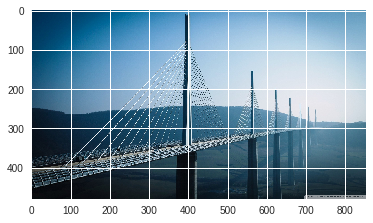

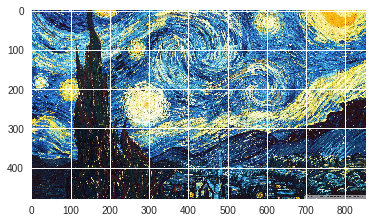

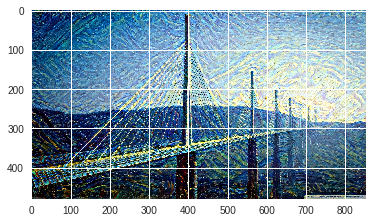

In [41]:
from matplotlib import pyplot as plt
%matplotlib inline
# Content image
plt.imshow(load_img(target_image, target_size=(height, width)))
plt.figure()

# Style image
plt.imshow(load_img(style_image, target_size=(height, width)))
plt.figure()

# Generate image
plt.imshow(img)
plt.show()